# Sparkify Project Workspace

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession,Window
from pyspark.sql.functions import avg, split, udf,count,sum,mean,round,col,max,min,lit
from pyspark.sql.types import IntegerType,DoubleType

from pyspark.ml import Pipeline,PipelineModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier,RandomForestClassifier,GBTClassifier,NaiveBayes

In [2]:
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify Project") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
stack_overflow_data = 'mini_sparkify_event_data.json'
df = spark.read.json(stack_overflow_data)
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
print("Number of rows before deleting NA :"+ str(df.dropna(how = "any", subset = ["userId", "sessionId"]).count()))
print("Number of rows after deleting NA :"+ str(df.count()))

Number of rows before deleting NA :286500
Number of rows after deleting NA :286500


In [5]:
df.select(df.userId,df.sessionId).dropDuplicates().sort(["userId","sessionId"]).show(5)

+------+---------+
|userId|sessionId|
+------+---------+
|      |        1|
|      |        3|
|      |        5|
|      |        6|
|      |        8|
+------+---------+
only showing top 5 rows



### Note 1 :
There are userId with empty string for some rows, which likely correspond to user who arent registered. Since we are interested in churn, we can delete those unregistred user.

In [6]:
def clean_data(df):
    
    """
    Input
    df: the dataframe to clean
    
    Output
    df: A clean dataframe with no nan userId and '' userId
    
    """
    
    df=df.dropna(how = "any", subset = ["userId", "sessionId"]).filter(df.userId!='')
    return df

df=clean_data(df)
print("Number of rows after cleaning :"+ str(df.count()))

Number of rows after cleaning :278154


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [7]:
df.select(df.page).dropDuplicates().sort(["page"]).show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [8]:
def churning(df):
    
    """
    Input
    df: the dataframe to add the churn column
    
    Output
    df: A dataframe with churn column
    
    """
    
    churned_user=[x.userId for x in df.filter(df.page=="Cancellation Confirmation").select('userId').dropDuplicates().collect()]
    return df.withColumn("churn",df.userId.isin(churned_user).cast("Integer"))

df =churning(df)

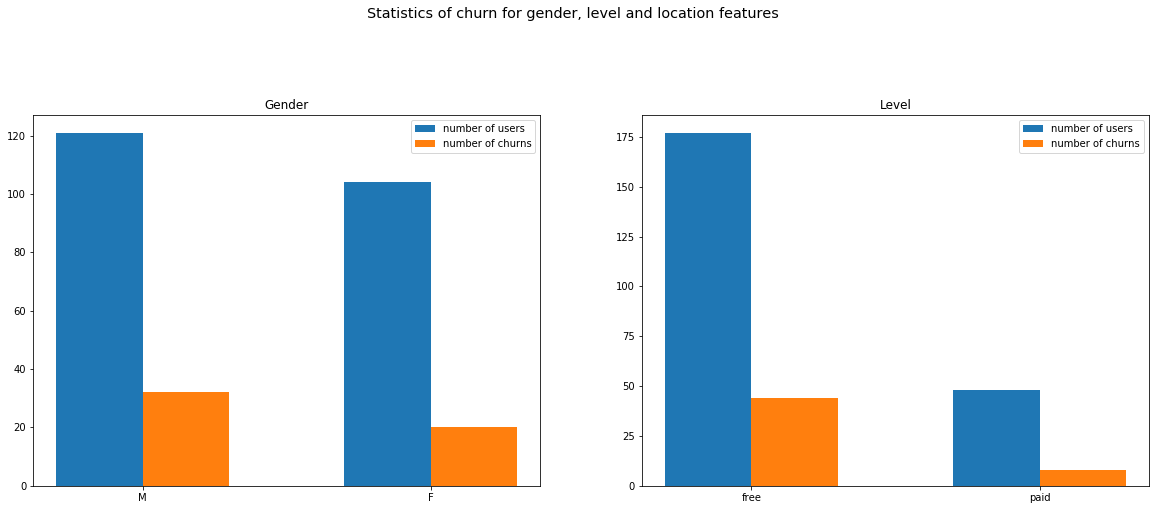

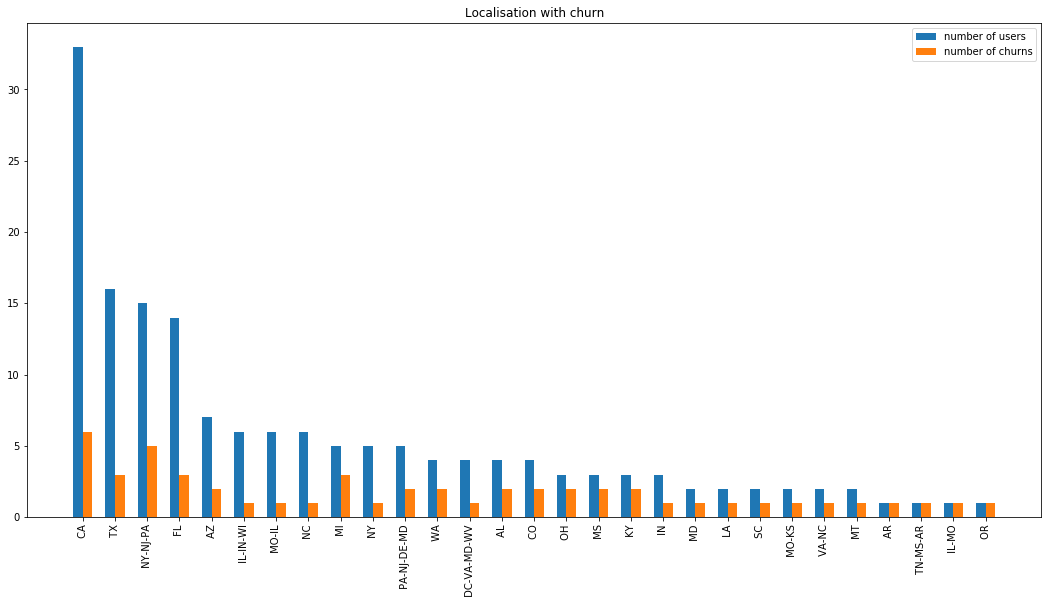

In [9]:
df=df.withColumn("location_level1",split(col("location"),",").getItem(1))
col_to_explore=['userId','gender','level','location_level1','churn']
df_explore=df.sort('ts').select(col_to_explore).dropDuplicates(subset=['userId'])
df_explore_gender=df_explore.groupby("gender").agg(sum('churn').alias('number of churns'),count('userId').alias('number of users')).sort(col('number of users').desc()).toPandas()
df_explore_level=df_explore.groupby("level").agg(sum('churn').alias('number of churns'),count('userId').alias('number of users')).sort(col('number of users').desc()).toPandas()
df_explore_location=df_explore.groupby("location_level1").agg(sum('churn').alias('number of churns'),count('userId').alias('number of users')).sort(col('number of users').desc()).toPandas()
df_explore_location=df_explore_location[df_explore_location['number of churns']>0]
fig = plt.figure(figsize=(20, 15))
fig.suptitle("Statistics of churn for gender, level and location features", fontsize="x-large")

width = 0.3

ax = fig.add_subplot(221)
x1 = np.arange(0, df_explore_gender.shape[0])
x2 = np.arange(0, df_explore_gender.shape[0])

ser1=ax.bar(x1, df_explore_gender['number of users'].values, width,tick_label = df_explore_gender["gender"].values)
ser2=ax.bar(x2 + width, df_explore_gender['number of churns'].values, width,tick_label = df_explore_gender["gender"].values)
ax.set_title('Gender')
ax.set_xticks(x1 + width / 2)
ax.legend((ser1[0], ser2[0]), ('number of users', 'number of churns'))

ax = fig.add_subplot(222)
x1 = np.arange(0, df_explore_level.shape[0])
x2 = np.arange(0, df_explore_level.shape[0])

ser1=ax.bar(x1, df_explore_level['number of users'].values, width,tick_label = df_explore_level["level"].values)
ser2=ax.bar(x2 + width, df_explore_level['number of churns'].values, width,tick_label = df_explore_level["level"].values)
ax.set_title('Level')
ax.set_xticks(x1 + width / 2)
ax.legend((ser1[0], ser2[0]), ('number of users', 'number of churns'))

fig = plt.figure(figsize=(40, 20))
ax = fig.add_subplot(223)
x1 = np.arange(0, df_explore_location.shape[0])
x2 = np.arange(0, df_explore_location.shape[0])

ser1=ax.bar(x1, df_explore_location['number of users'].values, width,tick_label = df_explore_location["location_level1"].values)
ser2=ax.bar(x2 + width, df_explore_location['number of churns'].values, width,tick_label = df_explore_location["location_level1"].values)
ax.set_title('Localisation with churn')
ax.set_xticks(x1 + width / 2)
ax.legend((ser1[0], ser2[0]), ('number of users', 'number of churns'))

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [10]:
def feature_engineering(df):
    """
    input:
    df: the initial dataframe from which the features will be extracted
    output:
    df_user: cleansed data to use in the models
    """
    df=df.withColumn("location_level1",split(col("location"),",").getItem(1))
    df=df.sort('ts')
    get_duree = udf(lambda x: x / (3600*1000.0))
    get_localisation = udf(lambda x: 1 if x.replace(' ','')=='CA' else 0)
    wdw = Window.partitionBy("userId")
    df = df.withColumn('last_ts', max('ts').over(wdw))
    df = df.withColumn('first_ts', min('ts').over(wdw))
    df=df.withColumn("duree", get_duree(df.last_ts-df.first_ts).cast(DoubleType()))
    #feature 1 - user's information : gender, level and localisation
    df_user=df.sort('ts').select(['userId','churn','gender','level','location_level1','duree']).dropDuplicates(subset=['userId'])
    df_user=df_user.withColumn("isCA",get_localisation(df_user.location_level1).cast(IntegerType()))
    df_user=df_user.replace(["M", "F"], ["0", "1"], "gender")
    df_user=df_user.replace(["free", "paid"], ["0", "1"], "level")
    df_user=df_user.withColumn("gender",df_user.level.cast(IntegerType()))
    df_user=df_user.withColumn("level",df_user.level.cast(IntegerType()))
    #feature 2 - user's interactions
    # Average song played in one session and number of songs played
    df_user_inter=df.filter((df.page=='NextSong')) \
            .groupBy('userID','sessionId') \
            .agg(count('sessionId').alias('nb_song')) \
            .groupBy('userID') \
            .agg(round(mean('nb_song'),0).alias('average_nb_song'),sum('nb_song').alias('nb_song'))
    # average time  between sessions
    df_time_session=df.select('userID','sessionId','duree').dropDuplicates() \
            .groupBy('userID','duree') \
            .agg(count('sessionId').alias('number_of_session'))

    df_time_session=df_time_session.withColumn('avg_time_session',df_time_session.duree/df_time_session.number_of_session)
    # Tumps up/down and upvote/downvote
    df_user_inter_tUP=df.filter((df.page=='Thumbs Up')) \
            .groupBy('userID','sessionId') \
            .agg(count('sessionId').alias('step')) \
            .groupBy('userID') \
            .agg(round(mean('step'),0).alias('av_tumpup'))
    df_user_inter_tDOWN=df.filter((df.page=='Thumbs Down')) \
            .groupBy('userID','sessionId') \
            .agg(count('sessionId').alias('step')) \
            .groupBy('userID') \
            .agg(round(mean('step'),0).alias('av_tumpdown'))
    
    df_user = df_user.join(df_user_inter,'userId',how="outer")
    df_user = df_user.join(df_user_inter_tUP,'userId',how="outer")
    df_user = df_user.join(df_user_inter_tDOWN,'userId',how="outer")
    df_user = df_user.join(df_time_session.select('userID','avg_time_session'),'userId',how="outer")
    df_user=df_user[['churn','gender','level','isCA','average_nb_song','av_tumpup','av_tumpdown','duree','avg_time_session','nb_song']]
    df_user = df_user.withColumnRenamed("churn", "label")

    df_user=df_user.fillna({ 'av_tumpup':0, 'av_tumpdown':0 })
    return df_user

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [11]:
df_model=feature_engineering(df)
df_model.printSchema()

root
 |-- label: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- isCA: integer (nullable = true)
 |-- average_nb_song: double (nullable = true)
 |-- av_tumpup: double (nullable = false)
 |-- av_tumpdown: double (nullable = false)
 |-- duree: double (nullable = true)
 |-- avg_time_session: double (nullable = true)
 |-- nb_song: long (nullable = true)



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  


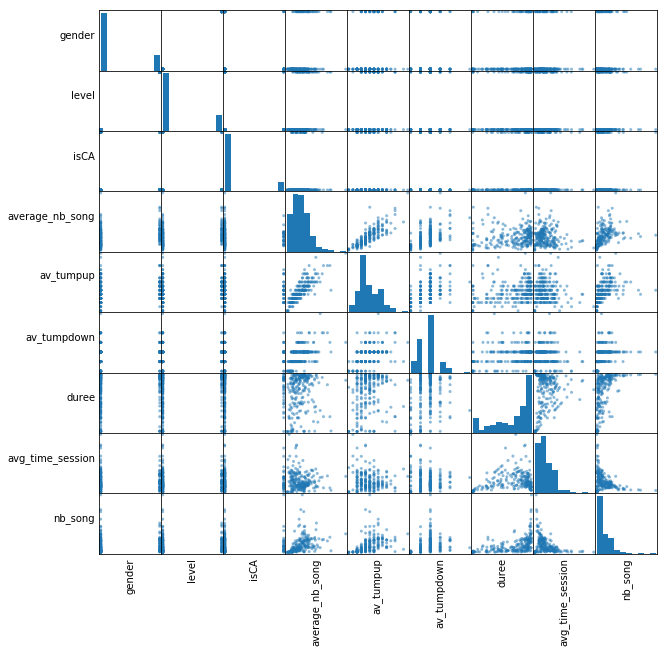

In [12]:
df_pds = df_model.toPandas()[df_model.columns[1:]]
axs = pd.scatter_matrix(df_pds, figsize=(10, 10));
n = len(df_pds.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [13]:
def train_models(df_model):
    """
    input:
    df_model: data to use for the modelling
    
    output
    trainned_model: dictionnary containing all the trainned model
    """
    
    #Splitting between train, test and validation
    df_model=feature_engineering(df)
    train, test_valid=df_model.randomSplit([0.7, 0.3], seed=42)
    test, valid=test_valid.randomSplit([0.5, 0.5], seed=42)
    assembler=VectorAssembler(inputCols=df_model.columns[1:],outputCol='features_int')
    scaler = StandardScaler(inputCol="features_int", outputCol="features", withStd=True)
    
    #Five model to test
    models={
        'Logistic Regression':LogisticRegression(maxIter=10),
        'Decission Tree Classifier':DecisionTreeClassifier(),
        'Random Forest Classifier':RandomForestClassifier(),
        'Gradient Boosted Tree':GBTClassifier(maxIter=10),
        'Naive Bayes':NaiveBayes()
    }
    
    #paramGrid for tuning
    paramGrid={
        'Logistic Regression':ParamGridBuilder() \
            .addGrid( models['Logistic Regression'].regParam, [0.01,0.0001]) \
            .build(),
        'Decission Tree Classifier':ParamGridBuilder()
             .addGrid(models['Decission Tree Classifier'].maxDepth, [2,  10])
             .addGrid(models['Decission Tree Classifier'].maxBins, [10, 40])
             .build(),
        'Random Forest Classifier': ParamGridBuilder() \
            .addGrid(models['Random Forest Classifier'].numTrees, [10, 50]) \
            .addGrid(models['Random Forest Classifier'].maxDepth, [2,  30]) \
            .build(),
        'Gradient Boosted Tree':ParamGridBuilder() \
            .addGrid(models['Gradient Boosted Tree'].maxBins, [10, 40]) \
            .addGrid(models['Gradient Boosted Tree'].maxDepth, [2, 30]) \
            .build(),
        'Naive Bayes':ParamGridBuilder() \
            .addGrid(models['Naive Bayes'].smoothing, [0.0,0.6])\
            .build()
    }
    
    trainned_model={}
    for mdl in models:
        print('Trainning model ' + mdl)
        print('...')
        pipeline = Pipeline(stages = [assembler,scaler, models[mdl]])
        crossval= CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid[mdl],
                          evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                          numFolds=3)
        model_test = crossval.fit(train)
        
        trainned_model[mdl]=model_test
        evaluator = MulticlassClassificationEvaluator()
        pred_train=model_test.transform(train)
        pred_test=model_test.transform(test)
        pred_valid=model_test.transform(valid)
        print(mdl + ' metrics:')
        print('Train - Accuracy: {:04.2f}% and F-1 Score: {:04.2f}%'.format(100*evaluator.evaluate(pred_train, {evaluator.metricName: "accuracy"}),100*evaluator.evaluate(pred_train, {evaluator.metricName: "f1"})))
        print('Test  - Accuracy: {:04.2f}% and F-1 Score: {:04.2f}%'.format(100*evaluator.evaluate(pred_test, {evaluator.metricName: "accuracy"}),100*evaluator.evaluate(pred_test, {evaluator.metricName: "f1"})))
        print('Valid - Accuracy: {:04.2f}% and F-1 Score: {:04.2f}%'.format(100*evaluator.evaluate(pred_valid, {evaluator.metricName: "accuracy"}),100*evaluator.evaluate(pred_valid, {evaluator.metricName: "f1"})))
        
    return trainned_model

In [14]:
trainned_model=train_models(df_model)

Trainning model Logistic Regression
...
Logistic Regression metrics:
Train - Accuracy: 84.66% and F-1 Score: 84.07%
Test  - Accuracy: 58.33% and F-1 Score: 53.70%
Valid - Accuracy: 92.00% and F-1 Score: 91.52%
Trainning model Decission Tree Classifier
...
Decission Tree Classifier metrics:
Train - Accuracy: 87.12% and F-1 Score: 87.18%
Test  - Accuracy: 66.67% and F-1 Score: 64.76%
Valid - Accuracy: 86.00% and F-1 Score: 83.21%
Trainning model Random Forest Classifier
...
Random Forest Classifier metrics:
Train - Accuracy: 99.39% and F-1 Score: 99.38%
Test  - Accuracy: 50.00% and F-1 Score: 40.62%
Valid - Accuracy: 92.00% and F-1 Score: 90.85%
Trainning model Gradient Boosted Tree
...
Gradient Boosted Tree metrics:
Train - Accuracy: 89.57% and F-1 Score: 89.29%
Test  - Accuracy: 58.33% and F-1 Score: 53.70%
Valid - Accuracy: 86.00% and F-1 Score: 83.21%
Trainning model Naive Bayes
...
Naive Bayes metrics:
Train - Accuracy: 77.91% and F-1 Score: 72.97%
Test  - Accuracy: 50.00% and F-1 S

The test and validation sets are very small, and are enough to test our models (12 rows). That explain the results of the models on these sets.